In [33]:
import json
from math import ceil
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

RESULTS_FOLDER = '../results'
SUBSETS = ['train_cnn', 'val', 'train_rnn', 'test']
FOLDS = [str(fold) for fold in range(1, 11)]

def get_metrics(exp_name, model_id):
    metrics_path = join(
        RESULTS_FOLDER, exp_name, f'model_{model_id}', 'metrics.json'
    )
    with open(metrics_path, 'r') as metrics_json:
        metrics_file = json.load(metrics_json)

    return metrics_file['metrics']

def n_bins(values):
    sorted_values = sorted(values)
    length = len(sorted_values)
    q1 = ceil(length / 4)
    q3 = ceil(length * 3 / 4)
    IQR = sorted_values[q3 - 1] - sorted_values[q1 - 1]
    h = 2 * IQR * (length ** (-1/3))
    max_value = values[-1]
    min_value = values[0]
    return ceil((max_value - min_value) / h)

In [6]:
model_metrics = get_metrics('hp_tf', '5')

In [24]:
model_metrics['1']['test']['33_PDNRKIBC'].keys()

dict_keys(['f1', 'rec', 'fp', 'pre', 'fn', 'acc', 'total', 'tp', 'tn', 'real', 'pred'])

In [17]:
f1_scores = [
    {
        'pb_name': pb_name,
        'f1': model_metrics[fold]['test'][pb_name]['f1'],
    }
    for fold in FOLDS
    for pb_name in model_metrics[fold]['test'].keys()
    
]
f1_scores.sort(key=lambda item: item['f1'])

In [44]:
def display_scores(scores):
    for score in scores:
        print(f'{score["pb_name"]} & ${score["f1"]:.2f}$ \\\\')

### Peores

In [45]:
display_scores(f1_scores[:5])

20_PD6M9KHG & $0.00$ \\
64_PDJJP4QL & $0.00$ \\
01_PD796ARA & $0.00$ \\
48_PDKS3P67 & $0.00$ \\
43_PDQWC1XR & $0.00$ \\


### Intermedios

In [46]:
display_scores(f1_scores[38:43])

38_PDRNCFK4 & $0.69$ \\
12_PDMAXIGK & $0.70$ \\
19_PDSTFKAK & $0.71$ \\
79_PD9S31N6 & $0.72$ \\
46_PD2DK5KB & $0.74$ \\


### Mejores

In [47]:
display_scores(f1_scores[-5:])

13_PD2SW1EO & $1.00$ \\
69_PDNVGH7Z & $1.00$ \\
65_PDY5C128 & $1.00$ \\
15_PDX94EF7 & $1.00$ \\
70_PDUPMC2M & $1.00$ \\


(array([13.,  3., 13., 19., 32.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

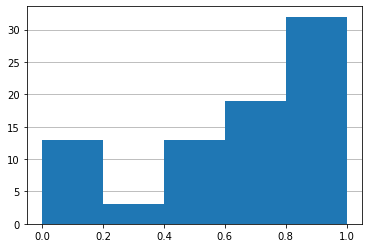

In [34]:
f1_values = [item['f1'] for item in f1_scores]
fig1, axs1 = plt.subplots(1, 1)
axs1.grid(axis='y')
axs1.set_axisbelow(True)
axs1.hist(f1_values, bins=n_bins(f1_values))

{'whiskers': [<matplotlib.lines.Line2D at 0x1a3b10ae7c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a3b10aee80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a3b10ae460>],
 'medians': [<matplotlib.lines.Line2D at 0x1a3b10bc580>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a3b10bc8e0>],
 'means': []}

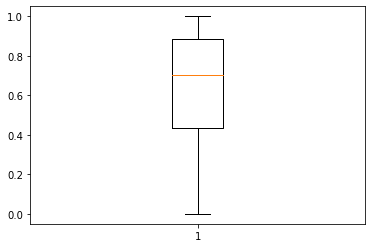

In [35]:
fig1, axs1 = plt.subplots(1, 1)
axs1.boxplot(f1_values)